### **Task 03**

#### Implement a **Support Vector Machine (SVM)** to classify the images of **Cats** and **Dogs**

In [1]:
import os
import zipfile
import shutil
import numpy as np
import cv2
from sklearn.decomposition import IncrementalPCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm

In [2]:
# Dataset Extraction
train_zip = "train.zip"
test_zip = "test1.zip"

# Extracting zip files
with zipfile.ZipFile(train_zip, 'r') as zip_ref:
    zip_ref.extractall()

with zipfile.ZipFile(test_zip, 'r') as zip_ref:
    zip_ref.extractall()

print("Dataset Extraction Complete.")

Dataset Extraction Complete.


In [3]:
# Organize Images into Folders
os.makedirs("train/cats", exist_ok=True)
os.makedirs("train/dogs", exist_ok=True)

for filename in os.listdir("train"):
    if filename.lower().startswith("cat") and filename.lower().endswith(".jpg"):
        shutil.move(os.path.join("train", filename), os.path.join("train/cats", filename))
    elif filename.lower().startswith("dog") and filename.lower().endswith(".jpg"):
        shutil.move(os.path.join("train", filename), os.path.join("train/dogs", filename))

print("Images organized into cats and dogs folders.")

Images organized into cats and dogs folders.


In [4]:
# Load and Resize Images
def load_images(folder_path, label, img_size=128):
    images = []
    labels = []
    for img_name in tqdm(os.listdir(folder_path), desc="Loading images"):
        img_path = os.path.join(folder_path, img_name)
        if not img_name.lower().endswith((".jpg")):
            continue
        try:
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error Loading Image {img_name}: {e}")
    return np.array(images, dtype=np.float32) / 255.0, np.array(labels)

In [5]:
# Load train images
cats_images, cats_labels = load_images("train/cats", label=0, img_size=128)
dogs_images, dogs_labels = load_images("train/dogs", label=1, img_size=128)
print(f"\n")
print(f"Loaded a total of {len(cats_images)+len(dogs_images)} images")

Loading images: 100%|████████████████████████████████████████████████████████████████████████| 12501/12501 [02:22<00:00, 87.62it/s]




Loaded a total of 25000 images


In [6]:
# Combine data
images = np.concatenate([cats_images, dogs_images], axis=0)
labels = np.concatenate([cats_labels, dogs_labels], axis=0)

In [7]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [8]:
del images, labels

In [9]:
# Reshape for PCA
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Fit PCA Incrementally 
pca = IncrementalPCA(n_components=400, batch_size=500)
for i in tqdm(range(0, X_train_flat.shape[0], 500), desc="Fitting PCA"):  # Batch size 500
    batch = X_train_flat[i:i+500]
    pca.partial_fit(batch)

# Transform Data in Batches due to storage issue
def batch_transform(data, transformer, batch_size=500):
    transformed = []
    for i in tqdm(range(0, data.shape[0], batch_size), desc="Transforming Data"):
        batch = data[i:i+batch_size]
        transformed.append(transformer.transform(batch))
    return np.vstack(transformed)

X_train_pca = batch_transform(X_train_flat, pca)
X_test_pca = batch_transform(X_test_flat, pca)

# Train SVM
svm = SVC(kernel='rbf', C=10)
svm.fit(X_train_pca, y_train)

Transforming Data: 100%|███████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.21it/s]


SVC(C=10)

In [10]:
del X_train_flat, X_test_flat
del X_train, X_test

Accuracy: 0.6890

Confusion Matrix:


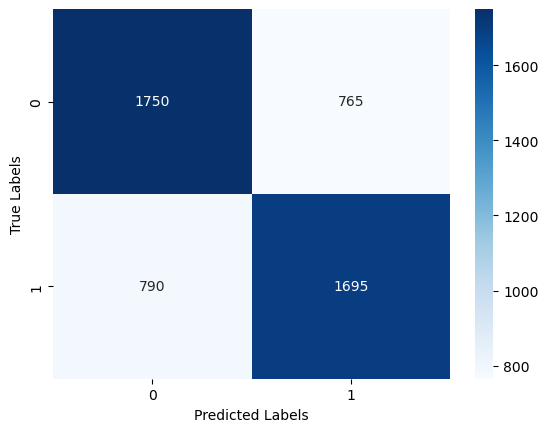


Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.70      0.69      2515
           1       0.69      0.68      0.69      2485

    accuracy                           0.69      5000
   macro avg       0.69      0.69      0.69      5000
weighted avg       0.69      0.69      0.69      5000



In [11]:
# Evaluate Model 
y_pred = svm.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

In [12]:
# Test Dataset Predictions 
test_images = []
test_labels = []
test_dir = "test1"

for img_name in tqdm(os.listdir(test_dir), desc="Loading Test Images"):
    img_path = os.path.join(test_dir, img_name)
    try:
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (128, 128))
        test_images.append(img)
        test_labels.append(img_name)
    except Exception as e:
        print(f"Error loading image {img_name}: {e}")

print(f"\n")
print(f"Loaded {len(test_images)} test images")

Loading Test Images: 100%|██████████████████████████████████████████████████████████████████| 12500/12500 [01:56<00:00, 107.66it/s]



Loaded 12500 test images


In [13]:
test_images = np.array(test_images, dtype=np.float32) / 255.0
test_images_flat = test_images.reshape(test_images.shape[0], -1)

In [14]:
# Apply PCA and predict in batches
test_images_pca = batch_transform(test_images_flat, pca)
test_predictions = svm.predict(test_images_pca)

Transforming Data: 100%|███████████████████████████████████████████████████████████████████████████| 25/25 [00:12<00:00,  2.01it/s]


In [15]:
# Save predictions
label_map = {0: "cat", 1: "dog"}
test_class_predictions = [label_map[label] for label in test_predictions]

results_df = pd.DataFrame({"Filename": test_labels, "Predictions": test_class_predictions})
results_df.to_csv("test_predictions.csv", index=False)
print("Predictions saved to test_predictions.csv.")

Predictions saved to test_predictions.csv.


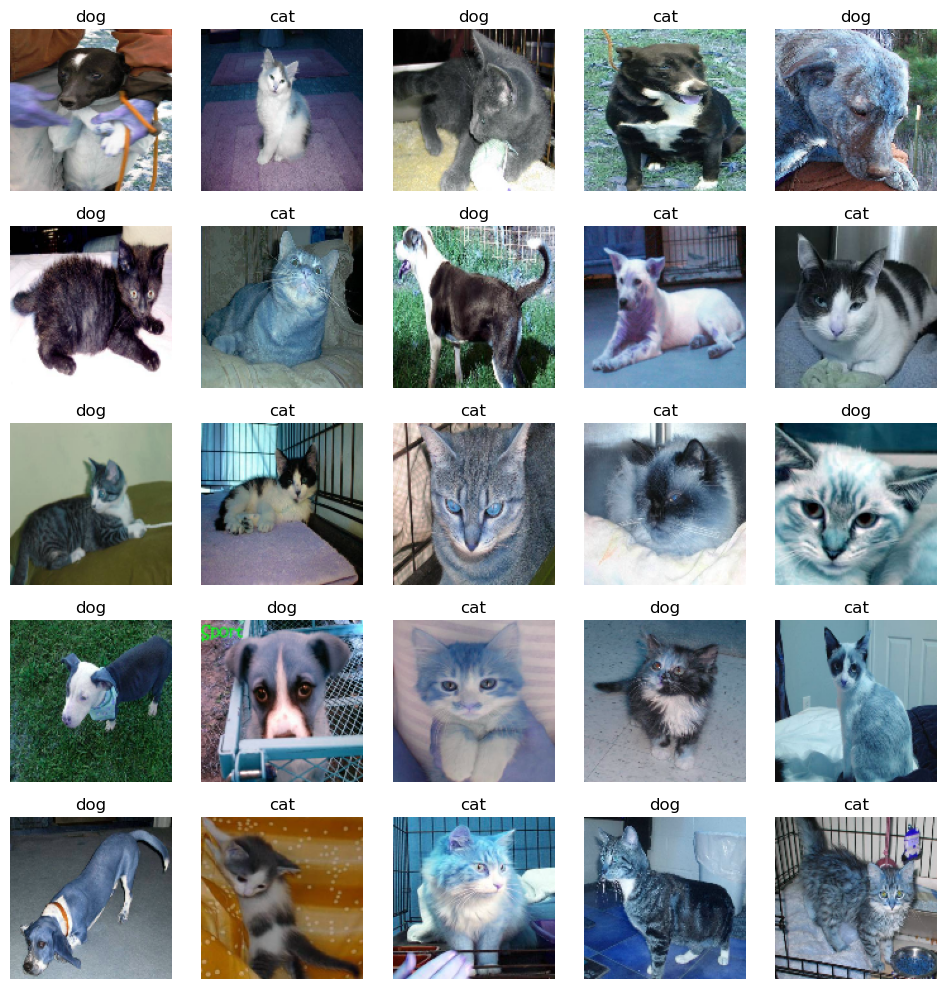

In [16]:
# Display sample test predictions
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[i])
    plt.title(test_class_predictions[i])
    plt.axis("off")
    plt.tight_layout()
plt.show()